# **PPM - Spaceship Titanic**

## Data Preparation

In [1]:
# Import semua library yang diperlukan
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split,  GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

In [2]:
# Baca data latih dari file CSV
train_df = pd.read_csv("../Datasets/train.csv")

# Pisahkan label dari data latih
train_labels = train_df.pop('Transported')

In [3]:
# Hapus kolom "Name" karena tidak diperlukan dalam analisis ini
train_df.drop(["Name"], axis=1, inplace=True)

In [4]:
# Ekstrak informasi dari kolom "Cabin" dan buat kolom baru "deck", "num", dan "side"
train_df[['deck', 'num', 'side']] = train_df['Cabin'].str.extract(r'(\w)(\d+)(\w)')

In [5]:
# Hapus kolom "Cabin" setelah ekstraksi informasi
train_df.drop(["Cabin"], axis=1, inplace=True)

In [6]:
# # Membuat fitur pengelompokan usia
# bins = [0, 5, 12, 17, 26, 36, 46, 56, np.inf]
# labels = ['Bayi', 'Kanak-kanak', 'Remaja Awal', 'Remaja Akhir', 'Dewasa Awal', 'Dewasa Akhir', 'Lansia Awal', 'Lansia Akhir']
# train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=bins, labels=labels)

# Membuat fitur total pengeluaran
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df['TotalSpend'] = train_df[amenities].sum(axis=1)

# Membuat fitur rasio pengeluaran dan usia
train_df['SpendAgeRatio'] = train_df['TotalSpend'] / train_df['Age']

In [7]:
# # Hapus kolom "Age" setelah ekstraksi informasi
# train_df.drop(["Age"], axis=1, inplace=True)

In [8]:
# Ekstrak informasi grup dari "PassengerId"
train_df["group"] = train_df["PassengerId"].str.split("_").str[0] 
train_df["group"] = pd.to_numeric(train_df["group"])

In [9]:
# Hapus "PassengerId" setelah ekstraksi informasi
train_df.drop("PassengerId", axis= 1, inplace= True)

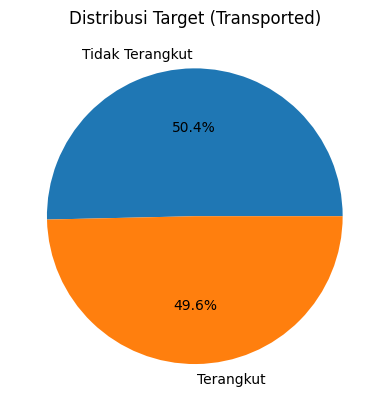

In [10]:
# Distribusi target
plt.pie(train_labels.value_counts(), labels=['Tidak Terangkut', 'Terangkut'], autopct='%1.1f%%')
plt.title('Distribusi Target (Transported)')
plt.show()

## Preprocessing Data

In [11]:
# Tentukan kolom kategorikal dan numerik
categorical_cols = train_df.select_dtypes(include=["bool_", "object_", "category"]).columns
numeric_cols = train_df.select_dtypes(exclude=["bool_", "object_", "category"]).columns

In [12]:
# # Lakukan encoding pada kolom kategorikal dengan OrdinalEncoder
# encoder = OrdinalEncoder()
# train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols])

In [13]:
# # Lakukan encoding pada kolom kategorikal dengan LabelEncoder
# encoder = LabelEncoder()
# for col in categorical_cols:
#     train_df[col] = encoder.fit_transform(train_df[col])

In [14]:
# Lakukan encoding dengan TargetEncoder
encoder = TargetEncoder()
train_df[categorical_cols] = encoder.fit_transform(train_df[categorical_cols], train_labels)

In [15]:
# Cek jumlah nilai yang hilang
train_df.isna().sum().sum()

1479

In [16]:
# Imputasi nilai yang hilang pada kolom numerik dengan IterativeImputer
iterative_imputer = IterativeImputer()
train_df[numeric_cols] = pd.DataFrame(iterative_imputer.fit_transform(train_df[numeric_cols]), columns= numeric_cols)

In [17]:
# Imputasi nilai yang hilang pada kolom kategorikal dengan SimpleImputer
categorical_imputer = SimpleImputer(strategy= "most_frequent")
train_df[categorical_cols] = pd.DataFrame(categorical_imputer.fit_transform(train_df[categorical_cols]), columns= categorical_cols)

In [18]:
# Cek kembali jumlah nilai yang hilang
train_df.isna().sum().sum()

0

In [19]:
# Lakukan penskalaan pada kolom numerik dengan StandardScaler
scaler = StandardScaler()
new_col_names = [col + "_scaled" for col in numeric_cols]

train_df[new_col_names] = scaler.fit_transform(train_df[numeric_cols]) 

In [20]:
# Hitung skor Mutual Information untuk setiap fitur
mi_scores = mutual_info_classif(train_df, train_labels)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=train_df.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

TotalSpend              0.135769
TotalSpend_scaled       0.131117
SpendAgeRatio           0.112989
CryoSleep               0.112680
SpendAgeRatio_scaled    0.112418
Spa_scaled              0.075916
Spa                     0.073786
RoomService             0.073186
RoomService_scaled      0.065981
VRDeck_scaled           0.062338
VRDeck                  0.060381
ShoppingMall_scaled     0.051886
FoodCourt               0.050537
FoodCourt_scaled        0.044224
ShoppingMall            0.041630
group                   0.024067
group_scaled            0.018509
Age_scaled              0.017394
HomePlanet              0.017131
Age                     0.013503
deck                    0.008448
Destination             0.004865
num                     0.001865
VIP                     0.000000
side                    0.000000
Name: MI Scores, dtype: float64

In [21]:
# Hapus kolom yang memiliki skor MI rendah dan double
train_df.drop(["Destination", "VIP", "TotalSpend", "SpendAgeRatio", "Spa", "RoomService", "VRDeck", "ShoppingMall", "FoodCourt", "Age"], axis= 1, inplace= True)

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HomePlanet            8693 non-null   float64
 1   CryoSleep             8693 non-null   float64
 2   deck                  8693 non-null   float64
 3   num                   8693 non-null   float64
 4   side                  8693 non-null   float64
 5   group                 8693 non-null   float64
 6   Age_scaled            8693 non-null   float64
 7   RoomService_scaled    8693 non-null   float64
 8   FoodCourt_scaled      8693 non-null   float64
 9   ShoppingMall_scaled   8693 non-null   float64
 10  Spa_scaled            8693 non-null   float64
 11  VRDeck_scaled         8693 non-null   float64
 12  TotalSpend_scaled     8693 non-null   float64
 13  SpendAgeRatio_scaled  8693 non-null   float64
 14  group_scaled          8693 non-null   float64
dtypes: float64(15)
memory

## Modeling and Evaluation

In [23]:
# Bagi data menjadi data latih dan validasi
X_train, X_valid, y_train, y_valid = train_test_split(train_df, train_labels, train_size=0.8)

In [24]:
# Function to perform hyperparameter tuning
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}")
    return grid_search.best_estimator_

In [25]:
# Buat model RandomForestClassifier dan latih model
rf = RandomForestClassifier(n_estimators=3000, random_state=42)
rf.fit(X_train, y_train)

# Cetak akurasi model RandomForestClassifier
print('RandomForestClassifier accuracy: ', accuracy_score(y_valid, rf.predict(X_valid)))

RandomForestClassifier accuracy:  0.78205865439908


In [26]:
# RandomForestClassifier tuning
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
rf_best = hyperparameter_tuning(rf, rf_params, X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.8002581859745848


In [27]:
# Buat model LogisticRegression dan latih model
lr = LogisticRegression(max_iter=3000, random_state=42)
lr.fit(X_train, y_train)

# Cetak akurasi model LogisticRegression
print('LogisticRegression accuracy: ', accuracy_score(y_valid, lr.predict(X_valid)))

LogisticRegression accuracy:  0.777458309373203


In [28]:
# LogisticRegression tuning
lr_params = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 300, 500]
}
lr = LogisticRegression(random_state=42)
lr_best = hyperparameter_tuning(lr, lr_params, X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for LogisticRegression: {'C': 10, 'max_iter': 300}
Best cross-validation accuracy: 0.7913429084194901


In [29]:
# Buat model GradientBoostingClassifier dan latih model
gbc = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.01, random_state=42)
gbc.fit(X_train, y_train)

# Cetak akurasi model GradientBoostingClassifier
print('GradientBoostingClassifier accuracy: ', accuracy_score(y_valid, gbc.predict(X_valid)))

GradientBoostingClassifier accuracy:  0.7906843013225991


In [30]:
# GradientBoostingClassifier tuning
gbc_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7]
}
gbc = GradientBoostingClassifier(random_state=42)
gbc_best = hyperparameter_tuning(gbc, gbc_params, X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for GradientBoostingClassifier: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation accuracy: 0.7996824395264521


In [31]:
# Buat model XGBClassifier dan latih model
class CustomXGBClassifier(XGBClassifier):
    def __init__(self, **params):
        super().__init__(**params)
        self.eval_set = params['eval_set']
    def fit(self, X, y):
        super().fit(X, y, eval_set=self.eval_set, verbose=100)
        
xgb = CustomXGBClassifier(n_estimators=3000, learning_rate=0.01, eval_set=[(X_valid, y_valid)], early_stopping_rounds=40, objective='binary:logistic')
xgb.fit(X_train, y_train)

# Cetak akurasi model XGBClassifier
print('XGBClassifier accuracy: ', accuracy_score(y_valid, xgb.predict(X_valid)))

[16:02:55] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set" } are not used.

[0]	validation_0-logloss:0.68890
[100]	validation_0-logloss:0.48794
[200]	validation_0-logloss:0.44367
[300]	validation_0-logloss:0.43036
[400]	validation_0-logloss:0.42503
[487]	validation_0-logloss:0.42442
XGBClassifier accuracy:  0.7901092581943646


In [32]:
# XGBClassifier tuning
xgb_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'eval_metric': ['logloss']
}
xgb = XGBClassifier(random_state=42)
xgb_best = hyperparameter_tuning(xgb, xgb_params, X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBClassifier: {'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.7995385546343659


In [34]:
# CatBoostClassifier tuning
cbc_params = {
    'iterations': [1000, 2000],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 8, 10]
} 
cbc = CatBoostClassifier(random_state=42, verbose=False)
cbc_best = hyperparameter_tuning(cbc, cbc_params, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for CatBoostClassifier: {'depth': 8, 'iterations': 1000, 'learning_rate': 0.01}
Best cross-validation accuracy: 0.8015527362437871


In [35]:
# Buat model KNeighborsClassifier dan latih model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Cetak akurasi model KNeighborsClassifier
print('KNeighborsClassifier accuracy: ', accuracy_score(y_valid, knn.predict(X_valid)))

KNeighborsClassifier accuracy:  0.5307648073605521


In [36]:
# KNeighborsClassifier tuning
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
knn_best = hyperparameter_tuning(knn, knn_params, X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy: 0.5517698048606405


In [37]:
# Buat model SVC dan latih model
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)

# Cetak akurasi model SVC
print('SVC accuracy: ', accuracy_score(y_valid, svc.predict(X_valid)))

SVC accuracy:  0.7625071880391029


In [38]:
# SVC tuning
svc_params = {
    'C': [0.1],
    'kernel': ['linear', 'rbf']
}
svc = SVC(random_state=42)
svc_best = hyperparameter_tuning(svc, svc_params, X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for SVC: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation accuracy: 0.7756676269336795


In [39]:
# Buat model DecisionTreeClassifier dan latih model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Cetak akurasi model DecisionTreeClassifier
print('DecisionTreeClassifier accuracy: ', accuracy_score(y_valid, dt.predict(X_valid)))

DecisionTreeClassifier accuracy:  0.7251293847038528


In [40]:
# DecisionTreeClassifier tuning
dt_params = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
dt = DecisionTreeClassifier(random_state=42)
dt_best = hyperparameter_tuning(dt, dt_params, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for DecisionTreeClassifier: {'max_depth': 10, 'min_samples_split': 5}
Best cross-validation accuracy: 0.7644537080615882


In [41]:
# Buat model GaussianNB dan latih model
nb = GaussianNB()
nb.fit(X_train, y_train)

# Cetak akurasi model GaussianNB
print('GaussianNB accuracy: ', accuracy_score(y_valid, nb.predict(X_valid)))

GaussianNB accuracy:  0.6670500287521565


In [42]:
# Buat model StackingClassifier
estimators = [
    ('xgb', xgb_best),
    ('rf', rf_best),
    ('lr', lr_best),
    ('gbc', gbc_best),
    ('cbc', cbc_best),
    ('knn', knn_best),
    ('svc', svc_best),
    ('dt', dt_best),
    ('nb', nb)
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=lr_best, cv=5)

# Latih model StackingClassifier
stacking_clf.fit(X_train, y_train)

# Cetak akurasi model StackingClassifier
print('StackingClassifier accuracy: ', accuracy_score(y_valid, stacking_clf.predict(X_valid)))

StackingClassifier accuracy:  0.7987349051178838


In [43]:
# Lakukan k-fold cross validation sebanyak 3 kali
cv_scores_stacking = cross_val_score(stacking_clf, X_train, y_train, cv=3)

# Cetak skor cross validation
print('StackingClassifier cross-validation scores: ', cv_scores_stacking)
print('StackingClassifier average cross-validation score: ', cv_scores_stacking.mean())

StackingClassifier cross-validation scores:  [0.79465056 0.79594478 0.80284728]
StackingClassifier average cross-validation score:  0.7978142076502731


In [47]:
# Buat model VotingClassifier dan latih model
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('lr', lr),
        ('gbc', gbc),
        ('cbc', cbc),
        ('knn', knn),
        ('svc', svc),
        ('dt', dt),
        ('nb', nb)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

# Cetak akurasi model VotingClassifier
print('VotingClassifier accuracy: ', accuracy_score(y_valid, voting_clf.predict(X_valid)))

VotingClassifier accuracy:  0.7935595169637722


In [45]:
# Lakukan k-fold cross validation sebanyak 3 kali
cv_scores_voting = cross_val_score(voting_clf, X_train, y_train, cv=3)

# Cetak skor cross validation
print('VotingClassifier cross-validation scores: ', cv_scores_voting)
print('VotingClassifier average cross-validation score: ', cv_scores_voting.mean())

VotingClassifier cross-validation scores:  [0.78861087 0.79206212 0.79421915]
VotingClassifier average cross-validation score:  0.7916307161345989


## Prediction and Submission

In [ ]:
# Baca data uji dari file CSV
test_df = pd.read_csv("../Datasets/test.csv")

In [ ]:
# Ekstrak informasi dari kolom "Cabin" dan buat kolom baru "deck", "num", dan "side"
test_df[['deck', 'num', 'side']] = test_df['Cabin'].str.extract(r'(\w)(\d+)(\w)')

In [ ]:
# Hapus kolom "Cabin" setelah ekstraksi informasi
test_df.drop(["Cabin"], axis=1, inplace=True)

In [ ]:
# # Membuat fitur pengelompokan usia
# bins = [0, 5, 12, 17, 26, 36, 46, 56, np.inf]
# labels = ['Bayi', 'Kanak-kanak', 'Remaja Awal', 'Remaja Akhir', 'Dewasa Awal', 'Dewasa Akhir', 'Lansia Awal', 'Lansia Akhir']
# test_df['AgeGroup'] = pd.cut(test_df['Age'], bins=bins, labels=labels)

# Membuat fitur total pengeluaran
amenities = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
test_df['TotalSpend'] = test_df[amenities].sum(axis=1)

# Membuat fitur rasio pengeluaran dan usia
test_df['SpendAgeRatio'] = test_df['TotalSpend'] / test_df['Age']

In [ ]:
# # Hapus kolom "Age" setelah ekstraksi informasi
# test_df.drop(["Age"], axis=1, inplace=True)

In [ ]:
# Ekstrak informasi grup dari "PassengerId"
test_df["group"] = test_df["PassengerId"].str.split("_").str[0]
test_df["group"] = pd.to_numeric(test_df["group"])

In [ ]:
# Lakukan encoding pada kolom kategorikal dengan OrdinalEncoder
test_df[categorical_cols] = encoder.transform(test_df[categorical_cols])

In [ ]:
# # Lakukan encoding pada kolom kategorikal dengan LabelEncoder
# for col in categorical_cols:
#     test_df[col] = encoder.fit_transform(test_df[col])

In [ ]:
# Imputasi nilai yang hilang pada kolom numerik dengan IterativeImputer
test_df[numeric_cols] = pd.DataFrame(iterative_imputer.transform(test_df[numeric_cols]), columns= numeric_cols)

In [ ]:
# Imputasi nilai yang hilang pada kolom kategorikal dengan SimpleImputer
test_df[categorical_cols] = pd.DataFrame(categorical_imputer.transform(test_df[categorical_cols]), columns= categorical_cols)

In [ ]:
# Lakukan penskalaan pada kolom numerik dengan StandardScaler
test_df[new_col_names] = scaler.transform(test_df[numeric_cols]) 

In [ ]:
# Prediksi label data uji
preds = [x == 1 for x in stacking_clf.predict(test_df[train_df.columns])]

In [ ]:
# Buat DataFrame untuk submisi
submission_df = pd.DataFrame({
    "PassengerId" : test_df["PassengerId"],
    "Transported" : preds
})

In [ ]:
# Simpan DataFrame submisi ke file CSV
submission_df.to_csv("../Submissions/submission_stcaking_v8.csv", index=False)